CLEANED RNN MODEL

In [1]:
#ACTIVATE AN INTERACTIVE SESSION FOR GPU UTILITY, ONLY DO THIS ONCE WHEN KERNEL I ACTIVATED TO AVOID OUT-OF-MEMORY ERRORS
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#ALL IMPORTS AND DESIGNATED FUNCTIONS

#1. Pandas Dataframe: Read Data, Data Manipulation
import pandas as pd

#2. clean_text function
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


#3. Tokenizer and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#4. Visualisation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#5. Train test split
from sklearn.model_selection import train_test_split

#6. Keras RNN model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, SimpleRNN, GRU
from keras.callbacks import EarlyStopping

In [3]:
labelled_data = pd.read_json('train.json')
answer_data = pd.read_json('test.json')

print(labelled_data.head())
print(answer_data.head())

sentiments = labelled_data['sentiments']

                                             reviews  sentiments
0  I bought this belt for my daughter in-law for ...           1
1  The size was perfect and so was the color.  It...           1
2  Fits and feels good, esp. for doing a swim rac...           1
3  These socks are absolutely the best. I take pi...           1
4  Thank you so much for the speedy delivery they...           1
                                             reviews
0  I bought 2 sleepers.  sleeper had holes in the...
1  I dare say these are just about the sexiest th...
2  everything about the transaction (price, deliv...
3  Not bad for just a shirt.  Very durable, and m...
4  These are truly wrinkle free and longer than t...


In [4]:
answer_data.shape

(1851, 1)

In [5]:
#VARIABLES USED FOR clean_text() function

nltk.download('stopwords')
nltk.download('wordnet')    

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

abbreviation_map = {
    "u": "you",
    "btw": "by the way",
    "omg": "oh my god",
    "idk": "I don't know",
    "lol": "laughing out loud",
    "pls": "please",
    "thx": "thanks",
    "im": "I am",
    "dont": "do not",
    "cant": "cannot",
    "wont": "will not",
}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
#clean_text function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Expand abbreviations
    text = ' '.join([abbreviation_map.get(word, word) for word in text.split()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [8]:
labelled_data['cleaned_reviews'] = labelled_data['reviews'].apply(clean_text)
answer_data['cleaned_reviews'] = answer_data['reviews'].apply(clean_text)

print(f'Labelled data:\n{labelled_data.head()}\n')
print(f'Answer data:\n {answer_data.head()}')

Labelled data:
                                             reviews  sentiments  \
0  I bought this belt for my daughter in-law for ...           1   
1  The size was perfect and so was the color.  It...           1   
2  Fits and feels good, esp. for doing a swim rac...           1   
3  These socks are absolutely the best. I take pi...           1   
4  Thank you so much for the speedy delivery they...           1   

                                     cleaned_reviews  
0         bought belt daughter inlaw christmas loved  
1            size perfect color looked like web page  
2  fit feel good esp swim race highly recommend c...  
3  sock absolutely best take pilate class hot foo...  
4  thank much speedy delivery came time rehearsal...  

Answer data:
                                              reviews  \
0  I bought 2 sleepers.  sleeper had holes in the...   
1  I dare say these are just about the sexiest th...   
2  everything about the transaction (price, deliv...   
3  Not 

In [9]:
# Tokenization: Divides the sentences into segments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(labelled_data['cleaned_reviews']) #Indexes each token (each word is given a number). Index = 0 is for padding

# Convert text to sequences
labelled_sequences = tokenizer.texts_to_sequences(labelled_data['cleaned_reviews'])
answer_sequences = tokenizer.texts_to_sequences(answer_data['cleaned_reviews'])

# Padding sequences
max_length = max(max(len(seq) for seq in labelled_sequences), max(len(seq) for seq in answer_sequences)) #Finding the maximum sequence length from both the raw_data and answer_data
labelled_final = pad_sequences(labelled_sequences, maxlen=max_length, padding='post') #standardize the array
answer_final = pad_sequences(answer_sequences, maxlen=max_length, padding='post')

# Display the shape of padded sequences
print(f'Train padded shape: {labelled_final.shape}')
print(f'Test padded shape: {answer_final.shape}')

print(f'The array matrix for labelled_final is:\n {labelled_final}')
print(f'The array matrix for answer_final is:\n {answer_final}')

Train padded shape: (7401, 518)
Test padded shape: (1851, 518)
The array matrix for labelled_final is:
 [[  15  255  185 ...    0    0    0]
 [   4   45   22 ...    0    0    0]
 [   8   36    9 ...    0    0    0]
 ...
 [1257  140   25 ...    0    0    0]
 [ 144  829  377 ...    0    0    0]
 [ 231  880   83 ...    0    0    0]]
The array matrix for answer_final is:
 [[  15  122 4282 ...    0    0    0]
 [2720   80 4719 ...    0    0    0]
 [ 176 1411   17 ...    0    0    0]
 ...
 [  18  116  213 ...    0    0    0]
 [ 185   11   58 ...    0    0    0]
 [1026  652  156 ...    0    0    0]]


In [10]:
# Load GloVe word embeddings (download and extract glove.6B.100d.txt)
embedding_dim = 100 #as vectors of n real numbers
glove_file = 'C:/Users/User/Downloads/Telegram Desktop/glove.6B/glove.6B.100d.txt' #change this to your glove path
embeddings_index = {}

with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors from GloVe.')

# Prepare the embedding matrix
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Map the words in the tokenizer's vocabulary to GloVe vectors
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Words found in GloVe will use pretrained vectors

# Check the embedding matrix shape
print(f'Embedding matrix shape: {embedding_matrix.shape}')

Loaded 400000 word vectors from GloVe.
Embedding matrix shape: (14876, 100)


c:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


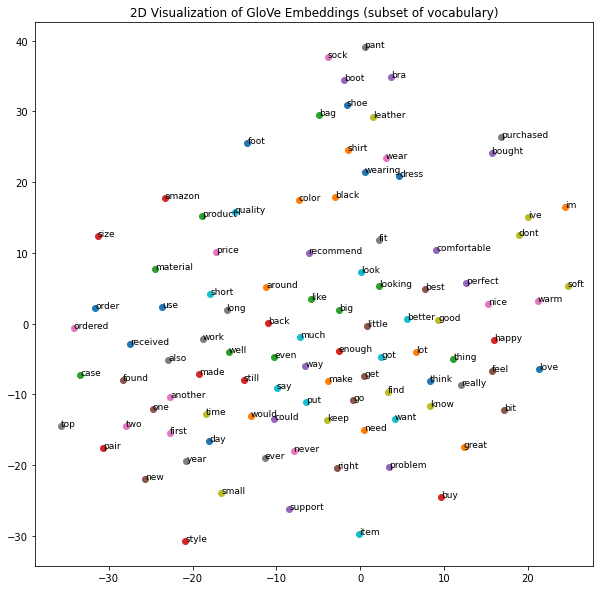

In [11]:
# Visualize the GloVe embeddings with t-SNE

# Step 1: Select a subset of words from the vocabulary (e.g., the first 100 words)
word_subset = list(tokenizer.word_index.keys())[:100]
word_vectors = np.array([embedding_matrix[tokenizer.word_index[word]] for word in word_subset])

# Step 2: Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
word_vecs_2d = tsne.fit_transform(word_vectors)

# Step 3: Plot the words in 2D space
plt.figure(figsize=(10, 10))
for i, word in enumerate(word_subset):
    plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
    plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=9)
plt.title("2D Visualization of GloVe Embeddings (subset of vocabulary)")
plt.show()

RNN MODEL TRAINING AND TESTING

In [12]:
#train test split the raw data
labelled_train, labelled_test, label_train, label_test = train_test_split(
    labelled_final, sentiments, test_size=0.2, random_state=42)

In [ ]:
#Simple RNN Model
n_iter = 0
test_accuracy_list = []
test_loss_list = []

while n_iter < 3:
    #This is a Bidirectional RNN Model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
    model.add(SimpleRNN(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=True,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(SimpleRNN(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=True,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(SimpleRNN(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=False,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Print the model summary
    model.summary()

    snn_model_history = model.fit(labelled_train, label_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

    print('Test Accuracy and Loss')
    loss, acc = model.evaluate(labelled_test, label_test)

    test_accuracy_list.append(round(acc, 4))
    test_loss_list.append(round(loss, 4))
    n_iter += 1

accuracy_average = sum(test_accuracy_list)/len(test_accuracy_list)
print(f'Test accuracy from the three iterations : {test_accuracy_list} and average: {round(accuracy_average,4)}')
print(f'Test loss list: {test_loss_list}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 518, 100)          1487600   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 518, 64)           10560     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 518, 64)           8256      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 518, 64)           8256      
                                                                 
 dense_1 (Dense)             (None, 518, 1)            65        
                                                                 
Total params: 1,514,737
Trainable params: 1,514,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
11/19 [================>.........

KeyboardInterrupt: 

In [ ]:
#LSTM RNN Model
n_iter = 0
test_accuracy_list = []
test_loss_list = []

while n_iter < 3:
    #This is a Bidirectional RNN Model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
    model.add(LSTM(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=True,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(Dropout(0.5))
    model.add(LSTM(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=False,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Print the model summary
    model.summary()

    snn_model_history = model.fit(labelled_train, label_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

    print('Test Accuracy and Loss')
    loss, acc = model.evaluate(labelled_test, label_test)

    test_accuracy_list.append(round(acc, 4))
    test_loss_list.append(round(loss, 4))
    n_iter += 1

accuracy_average = sum(test_accuracy_list)/len(test_accuracy_list)
print(f'Test accuracy from the three iterations : {test_accuracy_list} and average: {round(accuracy_average,4)}')
print(f'Test loss list: {test_loss_list}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 518, 100)          1487600   
                                                                 
 lstm (LSTM)                 (None, 518, 64)           42240     
                                                                 
 dropout (Dropout)           (None, 518, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 518, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 518, 64)           0         
                                                                 
 dense (Dense)               (None, 518, 1)            65        
                                                                 
Total params: 1,562,929
Trainable params: 1,562,929
Non-

In [ ]:
#GRU RNN Model
n_iter = 0
test_accuracy_list = []
test_loss_list = []

while n_iter < 3:
    #This is a Bidirectional RNN Model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
    model.add(GRU(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=True,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(Dropout(0.5))
    model.add(GRU(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=True,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(Dropout(0.5))
    model.add(GRU(64,
                    activation='tanh',  # Default settings, to show
                    return_sequences=False,  # Must be set to true for the first layer
                    recurrent_dropout=0,  # Must be 0 for cuDNN
                    unroll=False,  # Must be False for cuDNN
                    use_bias=True))  # Default is True
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Print the model summary
    model.summary()

    snn_model_history = model.fit(labelled_train, label_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

    print('Test Accuracy and Loss')
    loss, acc = model.evaluate(labelled_test, label_test)

    test_accuracy_list.append(round(acc, 4))
    test_loss_list.append(round(loss, 4))
    n_iter += 1

accuracy_average = sum(test_accuracy_list)/len(test_accuracy_list)
print(f'Test accuracy from the three iterations : {test_accuracy_list} and average: {round(accuracy_average,4)}')
print(f'Test loss list: {test_loss_list}')

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_92 (Embedding)    (None, 518, 100)          1487600   
                                                                 
 gru_43 (GRU)                (None, 518, 64)           31872     
                                                                 
 dropout_91 (Dropout)        (None, 518, 64)           0         
                                                                 
 gru_44 (GRU)                (None, 518, 64)           24960     
                                                                 
 dropout_92 (Dropout)        (None, 518, 64)           0         
                                                                 
 gru_45 (GRU)                (None, 518, 64)           24960     
                                                                 
 dropout_93 (Dropout)        (None, 518, 64)         

In [ ]:
#Bidirectional LSTM RNN Model
n_iter = 0
test_accuracy_list = []
test_loss_list = []

while n_iter < 3:
    #This is a Bidirectional RNN Model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
    model.add(Bidirectional(LSTM(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=False,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Print the model summary
    model.summary()

    snn_model_history = model.fit(labelled_train, label_train, batch_size=256, epochs=20, verbose=1, validation_split=0.2)

    print('Test Accuracy and Loss')
    loss, acc = model.evaluate(labelled_test, label_test)

    test_accuracy_list.append(round(acc, 4))
    test_loss_list.append(round(loss, 4))
    n_iter += 1

accuracy_average = sum(test_accuracy_list)/len(test_accuracy_list)
print(f'Test accuracy from the three iterations : {test_accuracy_list} and average: {round(accuracy_average,4)}')
print(f'Test loss list: {test_loss_list}')

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_120 (Embedding)   (None, 518, 100)          1487600   
                                                                 
 bidirectional_45 (Bidirecti  (None, 518, 128)         84480     
 onal)                                                           
                                                                 
 dropout_118 (Dropout)       (None, 518, 128)          0         
                                                                 
 bidirectional_46 (Bidirecti  (None, 518, 128)         98816     
 onal)                                                           
                                                                 
 dropout_119 (Dropout)       (None, 518, 128)          0         
                                                                 
 bidirectional_47 (Bidirecti  (None, 518, 128)      

In [ ]:
#Bidirectional GRU
n_iter = 0
test_accuracy_list = []
test_loss_list = []
callback = EarlyStopping (monitor='val_loss', patience=3)

while n_iter < 3:
    #This is a Bidirectional RNN Model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
    model.add(Dropout(0.5))
    model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=False,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Print the model summary
    model.summary()

    snn_model_history = model.fit(labelled_train, label_train, batch_size=256, epochs=30, callbacks = [callback], verbose=1, validation_split=0.2)

    print('Test Accuracy and Loss')
    loss, acc = model.evaluate(labelled_test, label_test)

    test_accuracy_list.append(round(acc, 4))
    test_loss_list.append(round(loss, 4))
    n_iter += 1

accuracy_average = sum(test_accuracy_list)/len(test_accuracy_list)
print(f'Test accuracy from the three iterations : {test_accuracy_list} and average: {round(accuracy_average,4)}')
print(f'Test loss list: {test_loss_list}')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 518, 100)          1487600   
                                                                 
 dropout_14 (Dropout)        (None, 518, 100)          0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 518, 128)         63744     
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, 518, 128)         74496     
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 518, 128)         74496     
 onal)                                                           
                                                      

In [ ]:
#GloVe vs. TFIDF benchmarking
n_iter = 0
test_accuracy_list = []
test_loss_list = []
callback = EarlyStopping (monitor='val_loss', patience=3)

while n_iter < 3:
    #This is a Bidirectional RNN Model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #CuDNN has very strict requirements to be able to use GPU, im putting it here to show the requirements, some of them are already default settings though
    model.add(Dropout(0.5))
    model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Print the model summary
    model.summary()

    snn_model_history = model.fit(labelled_train, label_train, batch_size=32, epochs=10, callbacks = [callback], verbose=1, validation_split=0.2)

    print('Test Accuracy and Loss')
    loss, acc = model.evaluate(labelled_test, label_test)

    test_accuracy_list.append(round(acc, 4))
    test_loss_list.append(round(loss, 4))
    n_iter += 1

accuracy_average = sum(test_accuracy_list)/len(test_accuracy_list)
print(f'Test accuracy from the three iterations : {test_accuracy_list} and average: {round(accuracy_average,4)}')
print(f'Test loss list: {test_loss_list}')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 518, 100)          1487600   
                                                                 
 dropout_8 (Dropout)         (None, 518, 100)          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 518, 128)         63744     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 518, 128)         74496     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 518, 128)         74496     
 onal)                                                           
                                                      

FINAL MODEL TO BE APPLIED TO THE TEST.JSON

In [12]:
answer_final.shape

(1851, 518)

In [40]:
#APPLY MODEL ON THE TEST SET
#Bidirectional GRU

callback = EarlyStopping (monitor='val_loss', patience=3)

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=True,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
model.add(Bidirectional(GRU(64,
                             activation='tanh',  # Default settings, to show
                             recurrent_activation='sigmoid',  # Default
                             return_sequences=False,  # Must be set to true for the first layer
                             recurrent_dropout=0,  # Must be 0 for cuDNN
                             unroll=False,  # Must be False for cuDNN
                             use_bias=True)))  # Default is True
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()
snn_model_history = model.fit(labelled_train, label_train, batch_size=32, epochs=30, callbacks = [callback], verbose=1, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 518, 100)          1487600   
                                                                 
 dropout_4 (Dropout)         (None, 518, 100)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 518, 128)         63744     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 518, 128)         74496     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                      

In [41]:
predictions = model.predict(answer_final)
predictions.shape

58/58 [==============================] - 6s 78ms/step


(1851, 1)

In [42]:
predicted_labels = (predictions > 0.5).astype(int)
predicted_labels.shape

(1851, 1)

In [43]:
#Saving in the excel file

print(f"Number of rows in existing Excel: {predicted_labels.shape[0]}")
print(f"Number of rows in existing Excel: {pd.read_json('test.json').shape[0]}")


Number of rows in existing Excel: 1851
Number of rows in existing Excel: 1851


In [44]:
file_path = 'test.json'

predictions_df = pd.DataFrame(predicted_labels)

predictions_df

,0
0,0
1,1
2,1
3,1
4,1
...,...
1846,1
1847,1
1848,1
1849,1


In [46]:
predictions_df[0].to_json(file_path, orient='records', lines=True)

print(f"Predictions have been saved to '{file_path}'")

Predictions have been saved to 'test.json'
